In [62]:
import pandas as pd
import numpy as np
from preprocess import base_data
from pathlib import Path
import hydra
import yaml
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import optuna
import os
from sklearn.metrics import log_loss
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

pd.set_option('display.max_columns', None)


In [63]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert coordinates from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Difference in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance

In [64]:
file_path = '../config/config.yaml'

# ファイルを開いて内容を読み込む
with open(file_path, 'r', encoding='utf-8') as file:
    yaml = yaml.safe_load(file)

# featuresリストを取得
features = yaml.get('features', [])

data = [pd.read_pickle(f"../features/{f}.pkl") for f in features]
data = pd.concat(data, axis=1)

In [65]:
data['Spring'] = data['ApprovalMonth'].isin([3, 4, 5]).astype(int)
data['Summer'] = data['ApprovalMonth'].isin([6, 7, 8]).astype(int)
data['Autumn'] = data['ApprovalMonth'].isin([9, 10, 11]).astype(int)
data['Winter'] = data['ApprovalMonth'].isin([12, 1, 2]).astype(int)


# Calculate the count of urban and rural businesses in each state
urban_rural_counts = data.groupby(['State', 'UrbanRural']).size().unstack(fill_value=0)

# Calculate the ratio of urban to rural businesses in each state
urban_rural_counts['UrbanRuralBusinessRatio'] = urban_rural_counts[1] / (urban_rural_counts[0] + urban_rural_counts[1])
urban_rural_counts = urban_rural_counts['UrbanRuralBusinessRatio']

# Merge this ratio back into the original dataframe
data = data.merge(urban_rural_counts, on='State', how='left')

# Handle possible division by zero
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# 各行の欠損値の数を計算
data['missing_values_count'] = data.isna().sum(axis=1)

In [66]:
state_to_coords = {
    'AL': (32.806671, -86.791130), 'AK': (61.370716, -152.404419), 'AZ': (33.729759, -111.431221),
    'AR': (34.969704, -92.373123), 'CA': (36.116203, -119.681564), 'CO': (39.059811, -105.311104),
    'CT': (41.597782, -72.755371), 'DE': (39.318523, -75.507141), 'FL': (27.766279, -81.686783),
    'GA': (33.040619, -83.643074), 'HI': (21.094318, -157.498337), 'ID': (44.240459, -114.478828),
    'IL': (40.349457, -88.986137), 'IN': (39.849426, -86.258278), 'IA': (42.011539, -93.210526),
    'KS': (38.526600, -96.726486), 'KY': (37.668140, -84.670067), 'LA': (31.169546, -91.867805),
    'ME': (44.693947, -69.381927), 'MD': (39.063946, -76.802101), 'MA': (42.230171, -71.530106),
    'MI': (43.326618, -84.536095), 'MN': (45.694454, -93.900192), 'MS': (32.741646, -89.678696),
    'MO': (38.456085, -92.288368), 'MT': (46.921925, -110.454353), 'NE': (41.125370, -98.268082),
    'NV': (38.313515, -117.055374), 'NH': (43.452492, -71.563896), 'NJ': (40.298904, -74.521011),
    'NM': (34.840515, -106.248482), 'NY': (42.165726, -74.948051), 'NC': (35.630066, -79.806419),
    'ND': (47.528912, -99.784012), 'OH': (40.388783, -82.764915), 'OK': (35.565342, -96.928917),
    'OR': (44.572021, -122.070938), 'PA': (40.590752, -77.209755), 'RI': (41.680893, -71.511780),
    'SC': (33.856892, -80.945007), 'SD': (44.299782, -99.438828), 'TN': (35.747845, -86.692345),
    'TX': (31.054487, -97.563461), 'UT': (40.150032, -111.862434), 'VT': (44.045876, -72.710686),
    'VA': (37.769337, -78.169968), 'WA': (47.400902, -121.490494), 'WV': (38.491226, -80.954570),
    'WI': (44.268543, -89.616508), 'WY': (42.755966, -107.302490)
}

# Apply the mapping to the dataset to create new latitude and longitude columns
data['Latitude'] = data['State'].map(lambda x: state_to_coords[x][0] if x in state_to_coords else None)
data['Longitude'] = data['State'].map(lambda x: state_to_coords[x][1] if x in state_to_coords else None)
data['BankState_Latitude'] = data['BankState'].map(lambda x: state_to_coords[x][0] if x in state_to_coords else None)
data['BankState_Longitude'] = data['BankState'].map(lambda x: state_to_coords[x][1] if x in state_to_coords else None)

# Calculate the distance between State and BankState
data['State_BankState_Distance'] = data.apply(lambda x: haversine(x['Latitude'], x['Longitude'], 
                                                                   x['BankState_Latitude'], x['BankState_Longitude']) 
                                              if pd.notnull(x['Latitude']) and pd.notnull(x['BankState_Latitude']) 
                                              else None, axis=1)

In [67]:
category_columns = ['RevLineCr', 'LowDoc', 'BankState']
# 各カテゴリ変数のカラムに 'Unknown' をカテゴリとして追加
for column in category_columns:
    data[column] = data[column].astype('category')
    if 'Unknown' not in data[column].cat.categories:
        data[column] = data[column].cat.add_categories('Unknown')

# 欠損値を 'Unknown' で埋める
data[category_columns] = data[category_columns].fillna('Unknown')
data = data.drop('FranchiseFlag',axis=1)

In [68]:
numerical_columns = [
    'LoanProcessingPeriod',
    'Jobs_Created_per_Employee',
    'Jobs_Retained_per_Employee',
    'Loan_Amount_per_Employee',
    'Latitude',
    'Longitude',
    'BankState_Latitude',
    'BankState_Longitude',
    'State_BankState_Distance',
    ]
for col in numerical_columns:
    # 各数値型カラムの中央値を計算
    medians = data[col].median()

    # 欠損値を中央値で補完
    data[col] = data[col].fillna(medians)

In [69]:
data = data.drop(['DisbursementYear','DisbursementMonth','DisbursementDay'],axis=1)

In [70]:
data.isna().sum()

ID                                    0
Term                                  0
NoEmp                                 0
NewExist                              0
CreateJob                             0
RetainedJob                           0
FranchiseCode                         0
RevLineCr                             0
LowDoc                                0
MIS_Status                        42308
Sector                                0
ApprovalFY                            0
City                                  0
State                                 0
BankState                             0
DisbursementGross                     0
GrAppv                                0
SBA_Appv                              0
UrbanRural                            0
train                                 0
NewBusiness                           0
ApprovalMonth                         0
ApprovalDay                           0
IsSameState                           0
LoanProcessingPeriod                  0


In [71]:
train = data[data["train"]==True].drop(columns="train")
test = data[data['train'] == False]
test = test.drop(['train','MIS_Status'],axis=1)


In [72]:
X = train[['Term']]
# スケーラーの初期化と適用
scaler = StandardScaler()
X = scaler.fit_transform(X)
# クラスタ数の候補を設定
n_components = np.arange(1, 10)

# BICを格納するためのリスト
bics = []

# 各クラスタ数に対してGMMをフィットし、BICを計算
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(X)
    bics.append(gmm.bic(X))

X = pd.DataFrame(X,columns=["Term"])

# クラスタ数を9に設定し、GMMをフィット
gmm = GaussianMixture(n_components=9, random_state=0)
gmm.fit(X)

# 各データポイントのクラスタ割り当てを取得
cluster_assignments = gmm.predict(X)

# クラスタ割り当て結果をデータフレームに追加
X_clustered = X.copy()
train['Term_Cluster'] = cluster_assignments

# 'Term' 列の選択
X_test = test[['Term']]

# 訓練データでフィットさせたGMMを使用してクラスタ割り当てを予測
test['Term_Cluster'] = gmm.predict(X_test)

In [73]:
train['MIS_Status'] = train['MIS_Status'].astype('int')

In [74]:
train = train.drop('City',axis=1)
test = test.drop('City',axis=1)

In [75]:
category_features = [
    'State',
    'BankState', 
    'Sector',  
    'NewExist',
    'UrbanRural',
    'RevLineCr', 
    'LowDoc',
    'IsSameState',
    'Term_Cluster',
    'Spring',
    'Summer',
    'Autumn',
    'Winter',
    'BankStateCount',
    'CityCount',
    'SectorCount',
    'StateCount',
    'RealEstate',
    'GreatRecession',
    'AppvDisbursed',
    
    ]

In [76]:
from category_encoders import CatBoostEncoder

for col in category_features:
    X = train[col]
    test_X = test[col]
    y = train['MIS_Status'].astype('int')

    encoder = CatBoostEncoder(cols=[col], a=0)

    encoder.fit(X, y)
    encoded_train = encoder.transform(X, y)
    encoded_test = encoder.transform(test_X)

    test.loc[:, f"ordered_{col}"] = encoded_test
    train.loc[:, f"ordered_{col}"] = encoded_train
    train = train.drop(col,axis=1)
    test = test.drop(col,axis=1)

In [78]:
list1 = ['ordered_State',
         'ordered_BankState',
 'ordered_Sector',
 'ordered_NewExist',
 'ordered_UrbanRural',
 'ordered_RevLineCr',
 'ordered_LowDoc',
 'ordered_Term_Cluster',
 'ordered_Spring',
'ordered_Summer',
'ordered_Autumn',
'ordered_Winter',
'ordered_BankStateCount',
'ordered_CityCount',
'ordered_SectorCount',
'ordered_StateCount',
'ordered_RealEstate',
'ordered_GreatRecession',
'ordered_AppvDisbursed',
 ]

for col in list1:
    # 各数値型カラムの中央値を計算
    medians = train[col].median()
    medians_test = test[col].median()
    # 欠損値を中央値で補完
    train[col] = train[col].fillna(medians)
    test[col] = test[col].fillna(medians)

In [79]:
# 設定
n_splits = 5
kf = KFold(n_splits=n_splits)

# OOF予測用の空配列
oof_preds = np.zeros(train.shape[0])

# テストデータ予測用の空配列
test_preds = np.zeros(test.shape[0])

# クロスバリデーション
for train_index, val_index in kf.split(train):
    X_train, X_val = train.iloc[train_index], train.iloc[val_index]

    # ここで目的変数を設定
    y_train, y_val = X_train['MIS_Status'], X_val['MIS_Status']
    
    X_train = X_train.drop(['MIS_Status'],axis=1)
    X_val = X_val.drop(['MIS_Status'],axis=1)
    
    # モデルの訓練
    model = RandomForestClassifier()
    model.fit(X_train, y_train)
    
    # OOF予測
    oof_preds[val_index] = model.predict_proba(X_val)[:, 1]
    
    test_preds += model.predict_proba(test)[:, 1] / n_splits

# 訓練データにOOF予測を追加
train['rf_preds'] = oof_preds

# テストデータに予測を追加
test['rf_preds'] = test_preds

In [80]:
# 訓練データとテストデータのCSVファイルに保存する列の選択
train_csv = train[['ID', 'rf_preds']]
test_csv = test[['ID', 'rf_preds']]

# CSVファイルに保存
train_csv_path = '../data/Stacking/rf/train_rf_predictions.csv'
test_csv_path = '../data/Stacking/rf/test_rf_predictions.csv'

train_csv.to_csv(train_csv_path, index=False)
test_csv.to_csv(test_csv_path, index=False)

In [81]:
X_train = train.drop('MIS_Status', axis=1)
y_train = train['MIS_Status']

# Further splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [82]:
X_train.isna().sum()

ID                                0
Term                              0
NoEmp                             0
CreateJob                         0
RetainedJob                       0
FranchiseCode                     0
ApprovalFY                        0
DisbursementGross                 0
GrAppv                            0
SBA_Appv                          0
NewBusiness                       0
ApprovalMonth                     0
ApprovalDay                       0
LoanProcessingPeriod              0
LoanvsApprovedAmountDifference    0
SBAGuaranteeRatio                 0
YearsSinceApproval                0
Jobs_Created_per_Employee         0
Jobs_Retained_per_Employee        0
Loan_Amount_per_Employee          0
LoanToValueRatio                  0
UrbanRuralBusinessRatio           0
missing_values_count              0
Latitude                          0
Longitude                         0
BankState_Latitude                0
BankState_Longitude               0
State_BankState_Distance    

In [83]:
params = {
    'objective': 'binary',  # 二値分類問題
    'metric': 'binary_logloss',  # 損失関数
    'num_leaves': 56,
    'min_data_in_leaf': 696,
    'class_weight': {1:1/7575,0:1/887},
    'random_state': 0,
    'extra_trees': True,
    'verbose': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.09342053957127938,    # default = 0.1,best=0.08
    'feature_fraction': 0.558114049397983,  # default = 1.0
}


In [84]:
# 各クラスのサンプル数を計算
class_counts = data['MIS_Status'].value_counts()

# 逆数に基づいて重みを計算
weights = 1.0 / class_counts

# 重みを正規化
weights_normalized = weights / weights.sum()

# 辞書形式でクラスの重みを設定
class_weights = {i: weights_normalized[i] for i in class_counts.index}

In [85]:
class_weights

{1: 0.10731084690476753, 0: 0.8926891530952324}

In [86]:


models = []
for seed in range(10):
    # データサンプリング
    train_sample = X_train.sample(frac=0.8, random_state=seed)
    y_sample = y_train[train_sample.index]

    # モデルの学習
    rf_clf = RandomForestClassifier(class_weight=class_weights)
    rf_clf.fit(train_sample, y_sample)

    # 検証データに対する予測
    y_pred = rf_clf.predict(X_val)
    y_pred_proba = rf_clf.predict_proba(X_val)[:, 1]  # AUCの計算に使用

    # メトリクスの計算
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)

    # モデルをリストに追加
    models.append(rf_clf)


In [87]:
# 3. すべてのモデルを使用してトレーニングセットとテストセットの予測を行う。
y_preds_train = []
y_preds_test = []
for model in models:
    y_preds_train.append(model.predict_proba(X_train)[:, 1])
    y_preds_test.append(model.predict_proba(X_val)[:, 1])

In [88]:
# 4. 予測結果を平均して、最終的な予測を得る。
y_pred_train = np.mean(y_preds_train, axis=0)
y_pred = np.mean(y_preds_test, axis=0)

In [89]:
print(roc_auc_score(y_val, y_pred))
total_cases = len(y_val)  # テストデータの総数
TP = (y_val == 1) & (y_pred >= 0.5)  # True positives
FP = (y_val == 0) & (y_pred >= 0.5)  # False positives
TN = (y_val == 0) & (y_pred < 0.5)  # True negatives
FN = (y_val == 1) & (y_pred < 0.5)  # False negatives

TP_count = sum(TP)
FP_count = sum(FP)
TN_count = sum(TN)
FN_count = sum(FN)

accuracy_TP = TP_count / total_cases * 100
misclassification_rate_FP = FP_count / total_cases * 100
accuracy_TN = TN_count / total_cases * 100
misclassification_rate_FN = FN_count / total_cases * 100

print("Total cases:", total_cases)
print("True positives:", TP_count, "(", "{:.2f}".format(accuracy_TP), "%)")
print("False positives:", FP_count, "(", "{:.2f}".format(misclassification_rate_FP), "%)")
print("True negatives:", TN_count, "(", "{:.2f}".format(accuracy_TN), "%)")
print("False negatives:", FN_count, "(", "{:.2f}".format(misclassification_rate_FN), "%)")

0.7603857702568453
Total cases: 8462
True positives: 7505 ( 88.69 %)
False positives: 742 ( 8.77 %)
True negatives: 145 ( 1.71 %)
False negatives: 70 ( 0.83 %)


In [90]:

print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
y_pred_binary = np.where(y_pred > 0.5, 1, 0)  # 0.5が閾値

# スコア関数の修正
score_funcs = [
    accuracy_score, 
    lambda y_true, y_pred: precision_score(y_true, y_pred, average='binary'), 
    lambda y_true, y_pred: recall_score(y_true, y_pred, average='binary'),
    lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary'),
    roc_auc_score  # この関数は確率をそのまま使用
]

# スコアの計算（roc_auc_score以外はy_pred_binaryを使用）
scores = [
    round(f(y_val, y_pred_binary if f != roc_auc_score else y_pred), 3)
    for f in score_funcs
]

print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.904, 0.91, 0.991, 0.949, 0.76


In [96]:
# 各モデルからの予測確率を集める
y_preds_proba = [model.predict_proba(test) for model in models]

# 予測確率の平均を計算する
y_proba_avg = np.mean(y_preds_proba, axis=0)

# 最も高い確率のクラスを選択する
y_new_pred = np.argmax(y_proba_avg, axis=1)

In [105]:
# 閾値を設定（例：0.5）
threshold = 0.82

# 閾値を超える確率を持つ予測を1とし、それ以外を0とする
y_pred_threshold = (y_proba_avg[:, 1] >= threshold).astype(int)

# 0と1の割合を計算
zeros = np.sum(y_pred_threshold == 0) / len(y_pred_threshold)
ones = np.sum(y_pred_threshold == 1) / len(y_pred_threshold)

# 結果を表示
print(f"0の割合: {zeros * 100:.5f}%")
print(f"1の割合: {ones * 100:.5f}%")

0の割合: 9.04793%
1の割合: 90.95207%


In [106]:
submit = pd.read_csv('../data/sample_submission.csv', header=None)

submit.iloc[:, 1] = y_new_pred.ravel()
filename = 'RF_base'

submit.to_csv('outputs/' + filename + '.csv', index=False,header=None)

In [107]:
# 特徴量の重要度を取得
importance = rf_clf.feature_importances_

# 特徴量の名前を取得
feature_names = X_train.columns

# 特徴量の重要度を降順にソート
indices = np.argsort(importance)[::-1]

# 特徴量の重要度を降順に表示
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feature_names[indices[f]], importance[indices[f]]))

 1) rf_preds                       0.069360
 2) ordered_UrbanRural             0.057942
 3) ordered_CityCount              0.047826
 4) ordered_RevLineCr              0.043034
 5) ordered_LowDoc                 0.040475
 6) NoEmp                          0.034431
 7) ordered_Term_Cluster           0.032630
 8) ordered_Sector                 0.027490
 9) ordered_SectorCount            0.027454
10) Term                           0.026123
11) LoanProcessingPeriod           0.024584
12) ordered_NewExist               0.024031
13) Loan_Amount_per_Employee       0.023648
14) ordered_AppvDisbursed          0.023424
15) ordered_Spring                 0.022935
16) ordered_GreatRecession         0.022796
17) ordered_RealEstate             0.022793
18) ordered_BankStateCount         0.022553
19) ordered_Autumn                 0.022288
20) ordered_BankState              0.022250
21) ordered_Summer                 0.021750
22) ordered_Winter                 0.021672
23) ID                          

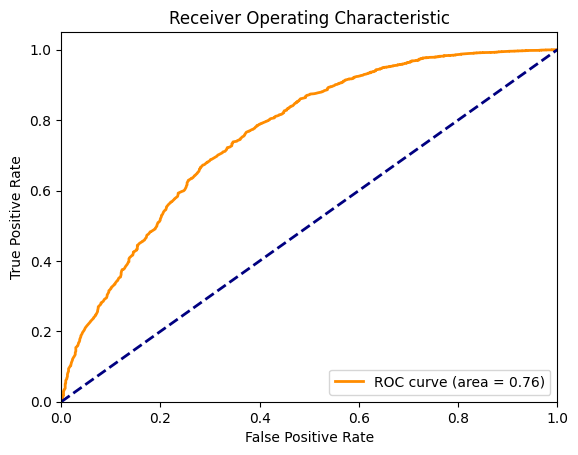

In [108]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# FPR, TPR, およびしきい値を計算する
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# AUC（Area Under Curve）を計算する
roc_auc = auc(fpr, tpr)

# ROC曲線をプロットする
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

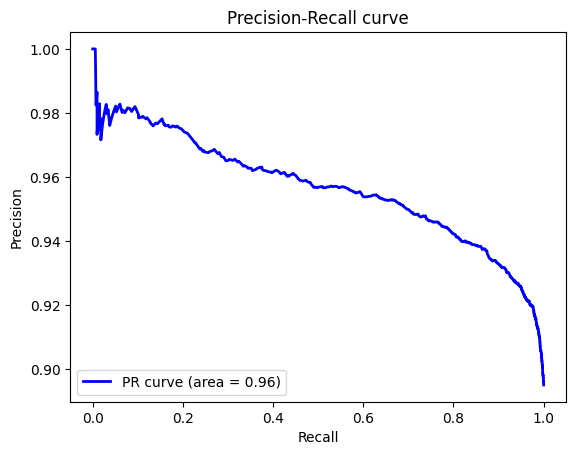

In [109]:
from sklearn.metrics import precision_recall_curve, auc

# 精度と再現率を計算
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

# PR AUCを計算
pr_auc = auc(recall, precision)

# PR曲線をプロット
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()